이 글은 책 "(처음부터)대규모 언어 모델 구축하기"에서 배운 내용을 하나의 파일로 정리해서 대규모 언어 모델에 대한 이해를 높이기 위해 작성되었습니다. 모든 단계의 세부 사항을 알고 싶다면 공식 [리포지토리](https://github.com/rasbt/LLMs-from-scratch)에서 확인 할 수 있습니다.

:::{.callout-warning}

시작하기 전에 딥러닝에 대한 기본 지식, 자연어 처리의 기초, 파이썬 프로그래밍 능력, 그리고 파이토치(PyTorch) 프레임워크 사용법을 어느 정도 알고 계시면 좋습니다. 이 정도 배경 지식이 있으면 내용을 더 쉽게 이해하실 수 있습니다.

:::

# 대규모 언어 모델이란?

대규모 언어 모델(LLM)은 자연어 처리 분야에 혁명을 일으켰습니다. 여기서 "대규모"라는 말은 모델의 매개변수 수와 훈련에 사용된 거대한 데이터셋을 모두 가리킵니다. 이런 모델들은 보통 수십억에서 수백억 개의 매개변수를 가지고 있어요. 이 매개변수들은 문장의 다음 단어를 예측하기 위해 훈련 과정에서 조정되는 네트워크의 가중치들이에요. 다음 단어를 예측하는 이 방식은 언어의 순차적인 특성을 잘 활용해서, 모델이 텍스트 속의 맥락, 구조, 관계를 이해하도록 만드는 데 아주 적합합니다.

대규모 언어 모델의 학습은 보통 두 단계로 이루어집니다. 먼저, 엄청난 양의 레이블 없는 텍스트 데이터를 사용해 다음 단어를 예측하는 사전 학습을 합니다. 그 다음 특정 작업을 위해 더 작은 규모의 레이블이 있는 데이터로 미세 조정을 거칩니다. 

여기에서는 GPT의 기본 아이디어를 청사진으로 삼아 세 단계로 재현해 봅니다.

## 환경 설정

먼저 라이브러리를 설치하고 가져온 다음 프로젝트 전반에서 사용할 수 있는 모든 변수를 초기화합니다.

In [ ]:
# 라이브러리 가져오기
import os
import urllib.request
from dataclasses import asdict, dataclass, replace

import numpy as np
import tiktoken as ttk
import torch
from torch import nn
from torch.utils.data import DataLoader, Dataset
from tqdm import tqdm

# 공식 리포지토리에서 작업할 원시 텍스트 가져오기
if not os.path.exists("../data/input/the-verdict.txt"):
    url = (
        "https://raw.githubusercontent.com/rasbt/"
        "LLMs-from-scratch/main/ch02/01_main-chapter-code/"
        "the-verdict.txt"
    )
    file_path = "../data/input/the-verdict.txt"
    urllib.request.urlretrieve(url, file_path)


@dataclass
class GPTConfig:
    vocab_size: int = 50257
    context_length: int = 512
    emb_dim: int = 768
    n_heads: int = 12
    n_layers: int = 12
    drop_rate: float = 0.1
    qkv_bias: bool = False

    def to_dict(self) -> dict:
        return asdict(self)

    def __repr__(self) -> str:
        config_dict = self.to_dict()
        formatted_items = [
            f'"{key}": {repr(value)}' for key, value in config_dict.items()
        ]
        return "GPT_CONFIG_124M = {\n    " + ",\n    ".join(formatted_items) + "\n}"


@dataclass
class DataConfig:
    dataPath: str = "../data/input/the-verdict.txt"
    max_length: int = GPTConfig.context_length
    batch_size: int = 64
    train_ratio: float = 0.9
    stride: int = GPTConfig.context_length


DataConfig = DataConfig()
GPTConfig = GPTConfig()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


def read_txt(path: str) -> str:
    try:
        with open(path, encoding="utf-8") as f:
            raw_text = f.read()
        return raw_text
    except FileNotFoundError:
        print(f"오류: {path}에서 파일을 찾을 수 없습니다")
        return ""
    except Exception as e:
        print(f"오류가 발생했습니다: {e}")
        return ""


def text_to_token_ids(text, tokenizer):
    encoded = tokenizer.encode(text)
    encoded_tensor = torch.tensor(encoded).unsqueeze(0)  # 배치 차원 추가
    return encoded_tensor


def token_ids_to_text(token_ids, tokenizer):
    flat = token_ids.squeeze(0)  # 배치 차원 제거
    return tokenizer.decode(flat.tolist())


class LLMDataset(Dataset):
    """
    언어 모델링을 위한 입력 및 목표 시퀀스로 텍스트 데이터를 처리하는 사용자 정의 Dataset입니다.

    인자:
        txt (str): 토큰화 및 처리될 입력 텍스트입니다.
        tokenizer (Tokenizer): 텍스트 인코딩에 사용될 토크나이저입니다.
        max_length (int): 각 입력 시퀀스의 최대 길이입니다.
        stride (int): 시퀀스 간 건너뛸 토큰의 수입니다.
    """

    def __init__(self, txt, tokenizer, max_length: int, stride: int):
        self.tokenizer = tokenizer
        token_ids = tokenizer.encode(txt)
        self.input_ids = []
        self.target_ids = []

        for i in tqdm(range(0, len(token_ids) - max_length, stride)):
            input_chunk = token_ids[i : i + max_length]
            target_chunk = token_ids[i + 1 : i + max_length + 1]
            self.input_ids.append(torch.tensor(input_chunk))
            self.target_ids.append(torch.tensor(target_chunk))

    def __len__(self):
        """
        데이터셋의 샘플 수를 반환합니다.
        """
        return len(self.input_ids)

    def __getitem__(self, idx):
        """
        지정된 인덱스의 입력 및 목표 시퀀스를 검색합니다.

        인자:
            idx (int): 검색할 시퀀스의 인덱스입니다.

        반환:
            tuple: (input_ids, target_ids) 두 텐서를 포함하는 튜플입니다.
        """
        return self.input_ids[idx], self.target_ids[idx]


def LLM_DataLoader(
    txt,
    tokenizer,
    batch_size: int,
    max_length: int,
    stride: int,
    shuffle: bool = True,
    drop_last: bool = True,
):
    """
    LLMDataset을 위한 DataLoader를 생성합니다.

    인자:
        txt (str): 토큰화 및 처리될 입력 텍스트입니다.
        tokenizer (Tokenizer): 텍스트 인코딩에 사용될 토크나이저입니다.
        batch_size (int): 로드할 배치당 샘플 수입니다.
        max_length (int): 각 입력 시퀀스의 최대 길이입니다.
        stride (int): 시퀀스 간 건너뛸 토큰의 수입니다.
        shuffle (bool, 선택적): 매 에폭마다 데이터를 섞을지 여부입니다. 기본값은 True입니다.
        drop_last (bool, 선택적): 마지막 불완전한 배치를 버릴지 여부입니다. 기본값은 True입니다.

    반환:
        DataLoader: LLMDataset을 위한 DataLoader 인스턴스입니다.
    """
    llmdataset = LLMDataset(txt, tokenizer, max_length, stride)
    llmdataloader = DataLoader(
        llmdataset, batch_size=batch_size, shuffle=shuffle, drop_last=drop_last
    )
    return llmdataloader


# 1단계

이 장에서는 대규모 언어 모델(LLM) 훈련을 위한 입력 텍스트 준비에 필요한 핵심 단계를 살펴봅니다. 먼저, 텍스트를 개별 단어와 하위 단어 토큰으로 분해하는 방법을 배우고, 이를 LLM 입력에 적합한 벡터 표현으로 변환하는 과정을 학습합니다. 또한 GPT와 같은 주요 모델에서 사용되는 바이트 페어 인코딩(BPE)과 같은 고급 토큰화 기법을 깊이 있게 다룹니다. 이어서 슬라이딩 윈도우를 사용한 샘플링 전략을 구현하여 훈련에 필요한 입력-출력 쌍을 생성하는 방법을 다룹니다. 주요 주제로는 단어 임베딩의 이해, 텍스트 토큰화, 토큰을 토큰 ID로 변환, 특수 컨텍스트 토큰의 역할 등이 포함됩니다. 또한 바이트 페어 인코딩이 토큰화를 개선하는 방법과 LLM에서 토큰 임베딩 및 위치 인코딩이 생성되고 사용되는 방식을 살펴봅니다.

## 데이터 준비 및 샘플링

### 이 책의 이 장에서는 무엇을 다루나요?

1. 단어 임베딩 이해하기:
   - 다양한 형태의 임베딩이 있습니다
   - LLM은 고차원 공간(즉, 수천 차원)에서 임베딩을 다룹니다
   - 우리는 그런 고차원 공간을 시각화할 수 없기 때문에(인간은 1, 2, 3차원으로 생각합니다), 아래 그림은 2차원 임베딩 공간을 보여줍니다

2. 텍스트 토큰화:
   - 텍스트를 개별 단어와 문장부호 같은 더 작은 단위로 나누는 것을 의미합니다
   - 간단한 샘플 텍스트를 기반으로 간단한 토크나이저를 개발하여 나중에 위의 텍스트에 적용할 수 있습니다

3. 토큰을 토큰 ID로 변환:
   - 텍스트 토큰을 나중에 임베딩 레이어로 처리할 수 있는 토큰 ID로 변환합니다
   - 이 토큰들로부터 모든 고유 토큰으로 구성된 어휘를 만들 수 있습니다

4. 특수 컨텍스트 토큰 추가:
   - 알 수 없는 단어와 텍스트의 끝을 나타내는 "특수" 토큰

5. 바이트페어 인코딩:
   - GPT-2는 토크나이저로 바이트페어 인코딩(BPE)을 사용했습니다
   - 이를 통해 모델은 미리 정의된 어휘에 없는 단어를 더 작은 하위 단어 단위나 개별 문자로 분해할 수 있어, 어휘 외 단어를 처리할 수 있습니다
   - 예를 들어, GPT-2의 어휘에 "unfamiliarword"가 없다면, 훈련된 BPE 병합에 따라 ["unfam", "iliar", "word"] 등으로 토큰화할 수 있습니다
   - 원래의 BPE 토크나이저는 여기에서 찾을 수 있습니다: https://github.com/openai/gpt-2/blob/master/src/encoder.py

> 이 프로젝트에서는 OpenAI의 오픈소스 tiktoken 라이브러리의 BPE 토크나이저를 사용합니다.

6. 데이터 샘플링:
   - LLM을 한 번에 한 단어씩 생성하도록 훈련시키므로, 시퀀스의 다음 단어가 예측할 대상을 나타내는 방식으로 훈련 데이터를 준비하고자 합니다


In [2]:
# the-verdict.txt를 로드하고 tiktoken의 인스턴스를 생성합니다
raw_data = read_txt(DataConfig.dataPath)
tokenizer = ttk.get_encoding("gpt2")

total_token = len(tokenizer.encode(raw_data))
print(f"-> 문자 수: {len(raw_data)}\n-> 토큰 수: {total_token}")


-> 문자 수: 20479
-> 토큰 수: 5145


In [3]:
# 다음으로, 데이터를 훈련용과 검증용으로 분할합니다
train_ratio = DataConfig.train_ratio
split_idxs = int(train_ratio * len(raw_data))
train_data = raw_data[:split_idxs]
val_data = raw_data[split_idxs:]
print(f"-> 훈련 데이터 길이: {len(train_data)}\n-> 검증 데이터 길이: {len(val_data)}")


# 정상 확인
if total_token * (train_ratio) < GPTConfig.context_length:
    print(
        "훈련 로더를 위한 토큰이 충분하지 않습니다. "
        "`GPTConfig.context_length`를 낮추거나 "
        "`training_ratio`를 높여보세요"
    )

if total_token * (1 - train_ratio) < GPTConfig.context_length:
    print(
        "검증 로더를 위한 토큰이 충분하지 않습니다. "
        "`GPTConfig.context_length`를 낮추거나 "
        "`training_ratio`를 낮춰보세요"
    )


-> 훈련 데이터 길이: 18431
-> 검증 데이터 길이: 2048


In [4]:
# LLM의 입력으로 사용할 수 있도록 데이터를 처리합니다
train_dataloader = LLM_DataLoader(
    txt=train_data,
    tokenizer=tokenizer,
    max_length=DataConfig.max_length,
    batch_size=DataConfig.batch_size,
    stride=DataConfig.stride,
    shuffle=False,
    drop_last=False,
)

print("예시 보기:")
dataiter = iter(train_dataloader)
firstbatch = next(dataiter)
print(f"입력: \n{firstbatch[0]} \n목표: \n{firstbatch[1]}")
firstbatch[0].shape


100%|██████████| 9/9 [00:00<00:00, 12098.95it/s]

예시 보기:
입력: 
tensor([[   40,   367,  2885,  ...,  9074,    13,   402],
        [  271, 10899,   550,  ...,   691, 12226,   318],
        [  284,  1234,  8737,  ..., 19217, 24887, 13431],
        ...,
        [ 1310,  1165,   881,  ...,   514,  2474,   198],
        [  198,  1544, 13818,  ...,   284,   616,   835],
        [  286,  1762,    30,  ...,  1517,   484,  1444]]) 
목표: 
tensor([[  367,  2885,  1464,  ...,    13,   402,   271],
        [10899,   550,   366,  ..., 12226,   318,   284],
        [ 1234,  8737,   656,  ..., 24887, 13431,    13],
        ...,
        [ 1165,   881, 40642,  ...,  2474,   198,   198],
        [ 1544, 13818,  4622,  ...,   616,   835,   286],
        [ 1762,    30,  2011,  ...,   484,  1444,   616]])


torch.Size([9, 512])

In [5]:
val_dataloader = LLM_DataLoader(
    txt=val_data,
    tokenizer=tokenizer,
    max_length=DataConfig.max_length,
    batch_size=DataConfig.batch_size,
    stride=DataConfig.stride,
    shuffle=False,
    drop_last=False,
)
dataiter = iter(val_dataloader)
firstbatch = next(dataiter)
firstbatch[0].shape


100%|██████████| 1/1 [00:00<00:00, 9915.61it/s]


torch.Size([1, 512])

이제 데이터가 훈련을 위해 준비되었습니다.

## 어텐션 메커니즘

**이 장에서 다루는 내용**

- 신경망에서 어텐션 메커니즘을 사용하는 이유 탐구
- 기본적인 셀프 어텐션 프레임워크 소개 및 향상된 셀프 어텐션 메커니즘으로의 발전
- LLM이 한 번에 하나의 토큰을 생성할 수 있게 하는 인과적 어텐션 모듈 구현
- 과적합을 줄이기 위해 무작위로 선택된 어텐션 가중치를 드롭아웃으로 마스킹
- 여러 인과적 어텐션 모듈을 멀티헤드 어텐션 모듈로 쌓기

### 어텐션에 대한 요약:
어텐션 메커니즘은 현대 딥러닝, 특히 자연어 처리(NLP)와 컴퓨터 비전 분야에서 핵심적인 개념입니다. 이는 모델이 입력 데이터의 특정 부분에 동적으로 집중할 수 있게 해주며, 마치 인간이 복잡한 작업을 처리할 때 관련 정보에 주의를 기울이는 것과 유사합니다.

Bahdanau 등이 기계 번역 맥락에서 소개한 어텐션 메커니즘은 모델이 다른 입력 요소의 중요성을 가중치로 부여할 수 있게 하여, 시퀀스의 장거리 의존성을 더 잘 처리할 수 있게 합니다. 이 메커니즘은 현재 작업과 관련하여 입력의 각 부분의 관련성을 결정하는 어텐션 가중치 집합을 계산하여, 모델이 가장 적절한 정보에 주목할 수 있게 합니다.

어텐션은 트랜스포머 아키텍처의 기반이 되는 셀프 어텐션을 포함한 다양한 형태로 발전했습니다. 셀프 어텐션은 모델이 시퀀스의 모든 부분을 동시에 고려할 수 있게 하여, 입력의 먼 요소 간의 관계를 포착하는 능력을 향상시킵니다. 이는 BERT, GPT, T5와 같은 모델에서 볼 수 있듯이 NLP에서 상당한 진전을 이끌었습니다.

컴퓨터 비전에서는 어텐션 메커니즘이 이미지 분류, 객체 탐지, 이미지 생성과 같은 작업의 성능을 향상시키기 위해 적용되었습니다. 여기서 어텐션은 모델이 이미지 내의 관련 공간 영역에 집중할 수 있게 하여 정확도와 해석 가능성을 개선합니다.

전반적으로, 어텐션 메커니즘은 모델이 복잡한 데이터를 처리하고 이해하는 방식을 혁신하여 다양한 AI 작업에서 높은 성능을 이끌어냈습니다.

어텐션 메커니즘에는 아래 4가지 유형이 있습니다.

1. Simplified self-attention
2. Self-attention
3. Causal attention
4. Multi-head attention


### 멀티헤드 어텐션:

멀티헤드 어텐션은 트랜스포머 아키텍처의 핵심 구성 요소로, 모델이 입력의 여러 부분에 동시에 집중할 수 있게 함으로써 어텐션 메커니즘의 능력을 향상시키도록 설계되었습니다. Vaswani 등이 "Attention is All You Need" 논문에서 소개한 멀티헤드 어텐션은 여러 어텐션 메커니즘을 병렬로 적용하여 데이터의 다양한 관계를 포착할 수 있게 합니다.

단일 어텐션 메커니즘에서는 입력 시퀀스가 쿼리(Q), 키(K), 값(V) 세 가지 벡터로 변환됩니다. 어텐션 점수는 쿼리와 키 벡터 간의 내적으로 계산되며, 이 점수는 값 벡터에 가중치를 부여하여 입력의 가장 관련성 높은 부분을 강조합니다.

멀티헤드 어텐션은 이 아이디어를 확장하여 각각 다른 "헤드"에 해당하는 여러 세트의 쿼리, 키, 값 벡터를 생성합니다. 이 헤드들은 서로 독립적이며 입력의 다른 측면에 집중하도록 학습될 수 있습니다. 예를 들어, 한 헤드는 지역적 맥락에 집중하고 다른 헤드는 장거리 의존성을 포착할 수 있습니다. 각 헤드에 대한 어텐션 점수를 계산한 후, 결과를 연결하고 선형 변환하여 최종 출력을 생성합니다.

이 접근 방식은 다음과 같은 여러 장점을 제공합니다:
- 병렬성: 여러 어텐션 헤드를 사용함으로써 모델은 입력의 다른 부분을 동시에 처리할 수 있어 더 풍부한 특징 표현이 가능합니다.
- 다양화: 각 헤드가 입력의 다른 부분에 주목하도록 학습될 수 있어, 모델이 데이터 내의 더 넓은 범위의 관계를 포착할 수 있습니다.
- 일반화 향상: 멀티헤드 어텐션은 학습 과정을 여러 헤드에 분산시켜 각 헤드가 데이터의 다른 측면에 집중하게 함으로써 과적합의 위험을 줄입니다.

In [ ]:
class MultiHeadAttention(nn.Module):
    """
    멀티헤드 어텐션 모듈.
    인자:
        d_in (int): 입력 차원.
        d_out (int): 출력 차원.
        context_length (int): 입력 시퀀스의 길이.
        dropout (float): 드롭아웃 확률.
        num_heads (int): 어텐션 헤드의 수.
        qkv_bias (bool, 선택적): 쿼리, 키, 값 투영에 편향을 포함할지 여부. 기본값은 False.
    속성:
        d_out (int): 출력 차원.
        num_heads (int): 어텐션 헤드의 수.
        head_dim (int): 각 어텐션 헤드의 차원.
        w_queries (nn.Linear): 쿼리를 위한 선형 투영.
        w_keys (nn.Linear): 키를 위한 선형 투영.
        w_values (nn.Linear): 값을 위한 선형 투영.
        out_proj (nn.Linear): 출력을 위한 선형 투영.
        dropout (nn.Dropout): 드롭아웃 레이어.
        mask (torch.Tensor): 인과성을 보장하기 위한 하삼각 마스크.
    """

    def __init__(
        self,
        d_in: int,
        d_out: int,
        context_length: int,
        dropout: float,
        num_heads: int,
        qkv_bias: bool = False,
    ):
        super().__init__()
        assert d_out % num_heads == 0, "d_out은 num_heads로 나누어 떨어져야 합니다"
        self.d_out = d_out
        self.num_heads = num_heads
        self.head_dim = d_out // num_heads

        self.w_queries = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.w_keys = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.w_values = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.out_proj = nn.Linear(d_out, d_out)
        self.dropout = nn.Dropout(dropout)

        self.register_buffer(
            "mask",
            torch.tril(torch.ones(context_length, context_length))
            .unsqueeze(0)
            .unsqueeze(0),
        )

    def forward(self, x):
        batches, num_tokens, dim_in = x.shape

        # 선형 투영
        queries = self.w_queries(x)
        keys = self.w_keys(x)
        values = self.w_values(x)

        # 멀티헤드 어텐션을 위한 reshape 및 transpose
        queries = queries.view(
            batches, num_tokens, self.num_heads, self.head_dim
        ).transpose(1, 2)
        keys = keys.view(batches, num_tokens, self.num_heads, self.head_dim).transpose(
            1, 2
        )
        values = values.view(
            batches, num_tokens, self.num_heads, self.head_dim
        ).transpose(1, 2)

        # 어텐션 점수 계산
        attn_scores = (queries @ keys.transpose(2, 3)) / (self.head_dim**0.5)

        # 마스크 적용: 배치와 헤드에 걸쳐 브로드캐스팅
        attn_scores = attn_scores.masked_fill(
            self.mask[:, :, :num_tokens, :num_tokens] == 0, float("-inf")
        )

        # 소프트맥스로 어텐션 가중치 얻기
        attn_weights = torch.softmax(attn_scores, dim=-1)
        attn_weights = self.dropout(attn_weights)

        # 컨텍스트 벡터 계산
        context_vec = (attn_weights @ values).transpose(1, 2)
        context_vec = context_vec.contiguous().view(batches, num_tokens, self.d_out)

        # 최종 선형 투영
        context_vec = self.out_proj(context_vec)

        return context_vec


## LLM 구축

- **GPT2의 아키텍처:**

```python
124백만 파라미터 GPT-2 모델의 구성 세부사항:
GPT_CONFIG_124M = {
    "vocab_size": 50257,    # 어휘 크기
    "context_length": 1024, # 컨텍스트 길이
    "emb_dim": 768,         # 임베딩 차원
    "n_heads": 12,          # 어텐션 헤드 수
    "n_layers": 12,         # 레이어 수
    "drop_rate": 0.1,       # 드롭아웃 비율
    "qkv_bias": False       # 쿼리-키-값 편향
}
```


**그림에 표시된 번호가 매겨진 상자들은 최종 GPT 아키텍처를 코딩하는 데 필요한 개별 개념들을 다루는 순서를 보여줍니다**

```mermaid
graph LR
    A[GPT Backbone] --> B[Layer Normalization]
    B --> C[GELU Activation]
    C --> D[Feed Forward Network]
    D --> E[Shortcut Connections]
    
    subgraph "Transformer Block"
        B
        C
        D
        E
    end
    
    E --> G[Final GPT Architecture]
```

### 레이어 정규화

많은 레이어를 가진 깊은 신경망을 훈련시키는 것은 때때로 그래디언트 소실이나 폭발과 같은 문제로 인해 어려울 수 있습니다. 이러한 문제들은 불안정한 훈련 동역학을 야기하고 네트워크가 가중치를 효과적으로 조정하기 어렵게 만듭니다. 이는 학습 과정이 손실 함수를 최소화하는 신경망의 파라미터(가중치) 세트를 찾는 데 어려움을 겪는다는 것을 의미합니다. 다시 말해, 네트워크가 정확한 예측이나 결정을 내릴 수 있을 정도로 데이터의 기본 패턴을 학습하는 데 어려움을 겪습니다.


In [ ]:
class LayerNorm(nn.Module):
    """
    레이어 정규화 모듈.
    인자:
        emb_dim (int): 입력 임베딩의 차원.
    속성:
        eps (float): 0으로 나누는 것을 방지하기 위한 작은 값.
        scale (nn.Parameter): 학습 가능한 스케일 파라미터.
        shift (nn.Parameter): 학습 가능한 이동 파라미터.
    """

    def __init__(self, emb_dim):
        super().__init__()
        self.eps = 1e-5
        self.scale = nn.Parameter(torch.ones(emb_dim))
        self.shift = nn.Parameter(torch.zeros(emb_dim))

    def forward(self, x):
        mean = x.mean(dim=-1, keepdim=True)
        var = x.var(dim=-1, keepdim=True)
        norm_x = (x - mean) / torch.sqrt(var + self.eps)
        return self.scale * norm_x + self.shift


### GELU 활성화 함수

* 딥러닝에서는 간단하면서도 효과적인 ReLU(Rectified Linear Unit) 활성화 함수가 다양한 신경망 구조에서 널리 사용됩니다.

* 대규모 언어 모델(LLM)에서는 전통적인 ReLU 외에도 다양한 종류의 활성화 함수가 사용됩니다. 그 중 주목할 만한 두 가지 예시로 GELU(Gaussian Error Linear Unit)와 SwiGLU(Swish-Gated Linear Unit)가 있습니다.

* GELU와 SwiGLU는 ReLU의 단순한 구분적 선형 함수와는 달리, 더 복잡하고 부드러운 활성화 함수입니다. GELU는 가우시안 분포를, SwiGLU는 시그모이드 게이트가 있는 선형 유닛을 각각 활용하여 딥러닝 모델에서 더 나은 성능을 제공합니다.

* GELU(Hendrycks와 Gimpel, 2016)는 여러 가지 방식으로 구현할 수 있습니다. 정확한 버전은 GELU(x)=x⋅Φ(x)로 정의되며, 여기서 Φ(x)는 표준 가우시안 분포의 누적 분포 함수입니다.

* 실제로는 계산 비용이 적은 아래와 같은 근사식을 사용하는 것이 일반적입니다:

$$
\text{GELU}(x) \approx 0.5 \cdot x \cdot \left(1 + \tanh\left[\sqrt{\frac{2}{\pi}} \cdot (x + 0.044715 \cdot x^3)\right]\right)
$$


In [ ]:
class GELU(nn.Module):
    """
    가우시안 오차 선형 유닛(GELU) 활성화 함수.
    이 구현은 다음의 근사식을 따릅니다:
    GELU(x) = 0.5 * x * (1 + tanh(sqrt(2/π) * (x + 0.044715 * x^3)))
    """

    def __init__(self):
        super().__init__()

    def forward(self, x):
        return (
            0.5
            * x
            * (
                1
                + torch.tanh(
                    torch.sqrt(torch.tensor(2.0 / torch.pi))
                    * (x + 0.044715 * torch.pow(x, 3))
                )
            )
        )


### 순방향 신경망


In [ ]:
class FeedForwardGELU(nn.Module):
    """
    GELU 활성화 함수를 사용한 순방향 신경망 층입니다.
    인자:
        cfg (dict): 'emb_dim'을 키로 가지는 설정 딕셔너리. 'emb_dim'은 임베딩 차원을 나타냅니다.
    네트워크 구조:
    - 입력을 'emb_dim'에서 4 * 'emb_dim'으로 투영하는 선형 층
    - GELU 활성화 함수
    - 4 * 'emb_dim'에서 다시 'emb_dim'으로 투영하는 선형 층
    """

    def __init__(self, cfg):
        super().__init__()
        emb_dim = cfg.emb_dim

        self.layers = nn.Sequential(
            nn.Linear(emb_dim, 4 * emb_dim),
            GELU(),
            nn.Linear(4 * emb_dim, emb_dim),
        )

    def forward(self, x):
        return self.layers(x)


### 지름길 연결 추가하기

* 이제 지름길 연결(shortcut connections)에 대해 알아볼까요? 이는 건너뛰기 연결(skip connections) 또는 잔차 연결(residual connections)이라고도 불립니다.

* 원래 지름길 연결은 컴퓨터 비전을 위한 깊은 신경망(잔차 네트워크)에서 제안되었습니다. 이는 기울기 소실 문제를 완화하기 위해서였죠.

* 지름길 연결은 기울기가 네트워크를 통해 흐를 수 있는 더 짧은 대체 경로를 만듭니다.

* 이는 한 층의 출력을 나중 층의 출력에 더하는 방식으로 구현됩니다. 보통 중간에 하나 이상의 층을 건너뛰게 됩니다.


### 트랜스포머 블록

이제 트랜스포머 블록을 구현해 볼 차례입니다. 이 블록은 GPT와 다른 대규모 언어 모델(LLM) 구조의 핵심 구성 요소입니다. 1억 2400만 개의 매개변수를 가진 GPT-2 구조에서는 이 블록이 열두 번 반복되는데요, 우리가 앞서 다룬 여러 개념들을 한데 모아놓은 것입니다. 여기에는 다중 헤드 어텐션, 층 정규화, 드롭아웃, 순방향 층, 그리고 GELU 활성화 함수가 포함됩니다. 이 트랜스포머 블록을 구현한 후에는 GPT 구조의 나머지 부분들과 연결할 예정입니다.

In [10]:
# 트랜스포머 구조 구축
class TransformerBlock(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.att = MultiHeadAttention(
            d_in=cfg.emb_dim,
            d_out=cfg.emb_dim,
            context_length=cfg.context_length,
            num_heads=cfg.n_heads,
            dropout=cfg.drop_rate,
            qkv_bias=cfg.qkv_bias,
        )
        self.ff = FeedForwardGELU(cfg)
        self.norm1 = LayerNorm(cfg.emb_dim)
        self.norm2 = LayerNorm(cfg.emb_dim)
        self.dropout = nn.Dropout(cfg.drop_rate)

    def forward(self, x):
        # 첫 번째 잔차 연결
        resid_conn = x
        x = self.norm1(x)  # 사전 층 정규화
        x = self.att(x)
        x = self.dropout(x)
        x = x + resid_conn

        # 두 번째 잔차 연결
        resid_conn = x
        x = self.norm2(x)
        x = self.ff(x)
        x = self.dropout(x)
        x = x + resid_conn
        return x


### 최종 GPT 아키텍처

In [11]:
# 설정에 따라 GPT 아키텍처를 구축
class GPTModel(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.tok_emb = nn.Embedding(cfg.vocab_size, cfg.emb_dim)
        self.pos_emb = nn.Embedding(cfg.context_length, cfg.emb_dim)
        self.dropout_emb = nn.Dropout(cfg.drop_rate)
        self.transformer_blocks = nn.Sequential(
            *[TransformerBlock(cfg) for _ in range(cfg.n_layers)]
        )
        self.final_norm = LayerNorm(cfg.emb_dim)
        self.out_ff = nn.Linear(cfg.emb_dim, cfg.vocab_size, bias=False)

    def forward(self, idx):
        batch_size, seq_len = idx.shape
        tok_embeds = self.tok_emb(idx)
        pos_embeds = self.pos_emb(torch.arange(seq_len, device=idx.device))

        x = tok_embeds + pos_embeds
        x = self.dropout_emb(x)
        x = self.transformer_blocks(x)
        x = self.final_norm(x)
        logits = self.out_ff(x)
        return logits


# 2단계

학습 함수를 작성하기 전에 알아야 할 것들:

1. GPT를 사용하여 텍스트를 생성하는 방법
2. 학습 세트와 검증 세트의 손실을 계산하는 방법

### 생성 함수

- 더 독창적인 텍스트를 생성하기 위한 텍스트 생성 전략(디코딩 전략이라고도 함)에 대해 다룰 예정입니다.
- 그 다음, 이 함수(탐욕적 방식)를 개선하기 위한 두 가지 기법인 *온도 스케일링*과 *상위-k 샘플링*에 대해 살펴보겠습니다.

In [12]:
def generate_text_simple(model, idx, max_new_tokens, context_size):
    # idx는 현재 컨텍스트의 인덱스를 나타내는 (B, T) 배열입니다
    for _ in range(max_new_tokens):
        # 지원되는 컨텍스트 크기를 초과하면 현재 컨텍스트를 자릅니다
        # 예: LLM이 5개의 토큰만 지원하고 컨텍스트 크기가 10이면
        # 마지막 5개의 토큰만 컨텍스트로 사용됩니다
        idx_cond = idx[:, -context_size:]

        # 예측 수행
        with torch.no_grad():
            logits = model(idx_cond)

        # 마지막 시간 단계에만 집중
        # (batch, n_token, vocab_size)가 (batch, vocab_size)로 변환됩니다
        logits = logits[:, -1, :]

        # 가장 높은 logits 값을 가진 어휘 항목의 idx를 얻습니다
        idx_next = torch.argmax(logits, dim=-1, keepdim=True)  # (batch, 1)

        # 샘플링된 인덱스를 실행 중인 시퀀스에 추가합니다
        idx = torch.cat((idx, idx_next), dim=1)  # (batch, n_tokens+1)

    return idx


def generate(
    model, idx, max_new_tokens, context_size, temperature=0.0, top_k=None, eos_id=None
):
    # 이전과 동일한 for 루프: logits를 얻고 마지막 시간 단계에만 집중합니다
    for _ in range(max_new_tokens):
        idx_cond = idx[:, -context_size:]
        with torch.no_grad():
            logits = model(idx_cond)
        logits = logits[:, -1, :]

        # 새로운 기능: top_k 샘플링으로 logits 필터링
        if top_k is not None:
            # 상위 k개의 값만 유지
            top_logits, _ = torch.topk(logits, top_k)
            min_val = top_logits[:, -1]
            logits = torch.where(
                logits < min_val, torch.tensor(float("-inf")).to(logits.device), logits
            )

        # 새로운 기능: 온도 스케일링 적용
        if temperature > 0.0:
            logits = logits / temperature

            # 소프트맥스를 적용하여 확률 얻기
            probs = torch.softmax(logits, dim=-1)  # (batch_size, context_len)

            # 분포에서 샘플링
            idx_next = torch.multinomial(probs, num_samples=1)  # (batch_size, 1)

        # 그렇지 않으면 이전과 동일: 가장 높은 logits 값을 가진 어휘 항목의 idx를 얻습니다
        else:
            idx_next = torch.argmax(logits, dim=-1, keepdim=True)  # (batch_size, 1)

        if (
            eos_id is not None and idx_next == eos_id
        ):  # eos_id가 지정되어 있고 시퀀스 종료 토큰이 발견되면 생성을 조기 종료합니다
            break

        # 이전과 동일: 샘플링된 인덱스를 실행 중인 시퀀스에 추가합니다
        idx = torch.cat((idx, idx_next), dim=1)  # (batch_size, num_tokens+1)

    return idx


def generate_and_print_sample(
    model, tokenizer, device, start_context, temperature, top_k, eos_id
):
    model.eval()
    context_size = model.pos_emb.weight.shape[0]
    encoded = text_to_token_ids(start_context, tokenizer).to(device)
    with torch.no_grad():
        token_ids = generate(
            model=model,
            idx=encoded,
            max_new_tokens=50,
            context_size=context_size,
            temperature=temperature,
            top_k=top_k,
            eos_id=eos_id,
        )
    decoded_text = token_ids_to_text(token_ids, tokenizer)
    print(decoded_text.replace("\n", " "))  # 간결한 출력 형식
    model.train()


### 학습 세트와 검증 세트의 손실 계산하기

In [13]:
def calc_loss_batch(input_batch, target_batch, model, device):
    # 입력과 타겟 배치를 지정된 장치로 이동
    input_batch, target_batch = input_batch.to(device), target_batch.to(device)
    # 모델을 통해 로짓 계산
    logits = model(input_batch)
    # 크로스 엔트로피 손실 계산
    loss = torch.nn.functional.cross_entropy(
        logits.flatten(0, 1), target_batch.flatten()
    )
    return loss


def calc_loss_loader(data_loader, model, device, num_batches=None):
    total_loss = 0.0
    if len(data_loader) == 0:
        return float("nan")
    elif num_batches is None:
        num_batches = len(data_loader)
    else:
        # num_batches가 데이터 로더의 배치 수를 초과하는 경우
        # 데이터 로더의 총 배치 수에 맞춰 num_batches를 줄임
        num_batches = min(num_batches, len(data_loader))
    for i, (input_batch, target_batch) in enumerate(data_loader):
        if i < num_batches:
            loss = calc_loss_batch(input_batch, target_batch, model, device)
            total_loss += loss.item()
        else:
            break
    return total_loss / num_batches


### 학습과 평가 방법

In [14]:
def train_model_simple(
    model,
    train_loader,
    val_loader,
    optimizer,
    device,
    num_epochs,
    eval_freq,
    eval_iter,
    start_context,
    tokenizer,
    temperature,
    top_k,
    eos_id,
):
    # 손실과 처리된 토큰 수를 추적하기 위한 리스트 초기화
    train_losses, val_losses, track_tokens_seen = [], [], []
    tokens_seen, global_step = 0, -1

    # 주요 학습 루프
    for epoch in range(num_epochs):
        model.train()  # 모델을 학습 모드로 설정
        optimizer.zero_grad()

        for input_batch, target_batch in train_loader:
            optimizer.zero_grad()  # 이전 배치 반복에서의 손실 그래디언트 초기화
            loss = calc_loss_batch(input_batch, target_batch, model, device)
            loss.backward()  # 손실 그래디언트 계산
            optimizer.step()  # 손실 그래디언트를 사용하여 모델 가중치 업데이트
            tokens_seen += input_batch.numel()
            global_step += 1

            # 선택적 평가 단계
            if global_step % eval_freq == 0:
                train_loss, val_loss = evaluate_model(
                    model, train_loader, val_loader, device, eval_iter
                )
                train_losses.append(train_loss)
                val_losses.append(val_loss)
                track_tokens_seen.append(tokens_seen)
                print(
                    f"에폭 {epoch+1} (스텝 {global_step:03d}): "
                    f"학습 손실 {train_loss:.3f}, 검증 손실 {val_loss:.3f}"
                )

        # 각 에폭 후 샘플 텍스트 출력
        print("예시: ")
        generate_and_print_sample(
            model, tokenizer, device, start_context, temperature, top_k, eos_id
        )
        print("-*-" * 10)

    return train_losses, val_losses, track_tokens_seen


def evaluate_model(model, train_loader, val_loader, device, eval_iter):
    model.eval()
    with torch.no_grad():
        train_loss = calc_loss_loader(
            train_loader, model, device, num_batches=eval_iter
        )
        val_loss = calc_loss_loader(val_loader, model, device, num_batches=eval_iter)
    model.train()
    return train_loss, val_loss


모델 학습

In [15]:
def initialize_weights(m):
    if isinstance(m, nn.Linear):
        # Xavier 균등 분포를 사용하여 가중치 초기화
        torch.nn.init.xavier_uniform_(m.weight)
        if m.bias is not None:
            # 편향을 0.01로 초기화
            m.bias.data.fill_(0.01)

# GPT 모델 초기화
model = GPTModel(GPTConfig)
model.to(device)
model.apply(initialize_weights)

# AdamW 옵티마이저 설정
optimizer = torch.optim.AdamW(model.parameters(), lr=0.00009, weight_decay=0.1)

# 그래디언트 클리핑 적용
torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

# 학습 설정
num_epochs = 50

# 모델 학습 실행
train_losses, val_losses, tokens_seen = train_model_simple(
    model,
    train_dataloader,
    val_dataloader,
    optimizer,
    device,
    num_epochs=num_epochs,
    eval_freq=5,
    eval_iter=5,
    start_context="Every effort moves",
    tokenizer=tokenizer,
    top_k=10,
    temperature=0.4,
    eos_id=None,
)


에폭 1 (스텝 000): 학습 손실 10.567, 검증 손실 10.596
예시: 
Every effort movesSecondessee frankly, harsh harsh the MILLacan  pictures MILL ate, theanu. Cut haircut, tipped arrives, I,((, Motsonian.,, ingers contribution,,, I. I.,, impairment flipped, haircut to.
-*--*--*--*--*--*--*--*--*--*-
예시: 
Every effort moves the,, the, pent,,  ,., the the.. ,, Nowcheon., I  ,   advantages I  IJonathan , to. ,,,,,,   
-*--*--*--*--*--*--*--*--*--*-
예시: 
Every effort moves,, the  the. to the, ,  I  of,,, the the ,,,, the,  , he,. -- of,,,, ,,, ,, I. 
-*--*--*--*--*--*--*--*--*--*-
예시: 
Every effort moves the the to the,,, to,.  , in, the he, , , he,.,,, in--,, ,,,,,,.    ,, the, I,
-*--*--*--*--*--*--*--*--*--*-
예시: 
Every effort moves the  --,.,,,--,,,,, I to , the--  to,-- ,----  --, to,, .... the,,.,  the,.
-*--*--*--*--*--*--*--*--*--*-
에폭 6 (스텝 005): 학습 손실 9.923, 검증 손실 10.025
예시: 
Every effort moves, the, , the.   the  ,--.,, he. Now. I ,. of I, of the,,  , he,    of the., of,,, in,
-*--*--*--*--*--*--*-

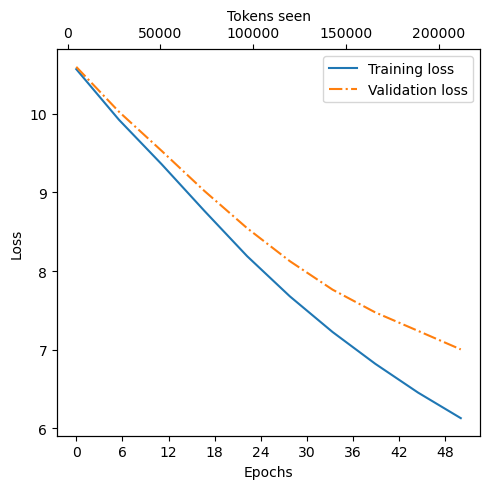

In [16]:
# Ep 46 (Step 045): Train loss 5.668, Val loss 6.691 ->4

import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator


def plot_losses(epochs_seen, tokens_seen, train_losses, val_losses):
    fig, ax1 = plt.subplots(figsize=(5, 5))

    # 에폭에 대한 학습 및 검증 손실 그래프 그리기
    ax1.plot(epochs_seen, train_losses, label="Training loss")
    ax1.plot(epochs_seen, val_losses, linestyle="-.", label="Validation loss")
    ax1.set_xlabel("Epochs")
    ax1.set_ylabel("Loss")
    ax1.legend(loc="upper right")
    ax1.xaxis.set_major_locator(MaxNLocator(integer=True))  # x축에 정수 레이블만 표시
    # 처리된 토큰 수에 대한 두 번째 x축 생성
    ax2 = ax1.twiny()  # 같은 y축을 공유하는 두 번째 x축 생성
    ax2.plot(tokens_seen, train_losses, alpha=0)  # 눈금 정렬을 위한 보이지 않는 그래프
    ax2.set_xlabel("Tokens seen")
    fig.tight_layout()  # 레이아웃 조정
    plt.show()


epochs_tensor = torch.linspace(0, num_epochs, len(train_losses))
plot_losses(epochs_tensor, tokens_seen, train_losses, val_losses)


In [17]:
model.to("cpu")
model.eval()


token_ids = generate(
    model=model,
    idx=text_to_token_ids("quite insensible to the irony", tokenizer),
    max_new_tokens=25,
    context_size=GPTConfig.context_length,
    top_k=5,
    temperature=0.7,
    eos_id=None,
)

print("Output text:\n", token_ids_to_text(token_ids, tokenizer))


Output text:
 quite insensible to the irony, the, the, and--I,,,, and--,, I had, I was, I had to


🚩 학습 손실과 검증 손실 모두 첫 번째 에폭에서 개선되기 시작합니다. 하지만 두 번째 에폭을 지나면서 두 손실 값이 갈라지기 시작하죠. 이렇게 두 손실이 벌어지고, 검증 손실이 학습 손실보다 훨씬 크다는 사실은 모델이 학습 데이터에 과적합되고 있음을 나타냅니다. 우리는 생성된 텍스트 조각들을 검색해봄으로써 모델이 학습 데이터를 그대로 암기하고 있다는 것을 확인할 수 있습니다.

## PyTorch에서 모델 가중치 저장하고 불러오기

* 대규모 언어 모델(LLM)을 학습하는 데는 많은 계산 비용이 들기 때문에, LLM의 가중치를 저장하고 불러올 수 있는 능력이 매우 중요합니다.
* PyTorch에서 권장하는 방법은 모델 가중치, 즉 'state_dict'라고 불리는 것을 저장하는 것입니다. 이는 .state_dict() 메서드에 torch.save 함수를 적용하여 수행합니다.
* 적응형 옵티마이저들은 각 모델 가중치에 대한 추가 매개변수를 저장합니다. 따라서 나중에 사전 학습을 계속하려는 경우를 대비해 이들도 함께 저장하는 것이 좋습니다.

In [18]:
# 모델 가중치만 저장:
# torch.save(model.state_dict(), "model.pth")
# # 그런 다음 새로운 GPTModel 모델 인스턴스에 모델 가중치를 다음과 같이 불러올 수 있습니다:
# model = GPTModel(GPT_CONFIG_124M)
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# model.load_state_dict(torch.load("model.pth", map_location=device, weights_only=True))
# model.eval();

# 모델 가중치와 옵티마이저 저장하기
print("모델과 옵티마이저 저장 중...")
torch.save(
    {
        "model_state_dict": model.state_dict(),
        "optimizer_state_dict": optimizer.state_dict(),
    },
    "model_and_optimizer.pth",
)
print("완료")


모델과 옵티마이저 저장 중...
완료


In [19]:
# 모델 삭제
del model

print("그런 다음 메모리에서 모델을 삭제하여 로드한 모델을 사용하도록 합니다.")


그런 다음 메모리에서 모델을 삭제하여 로드한 모델을 사용하도록 합니다.


In [20]:
# 모델과 옵티마이저 불러오기
print("불러오는 중...")
checkpoint = torch.load("model_and_optimizer.pth", weights_only=True)

model = GPTModel(GPTConfig)
model.to(device)
model.load_state_dict(checkpoint["model_state_dict"])

optimizer = torch.optim.AdamW(model.parameters(), lr=0.0005, weight_decay=0.1)
optimizer.load_state_dict(checkpoint["optimizer_state_dict"])
model.train()
print("완료")


불러오는 중...
완료


In [21]:
# 이제 다시 학습하거나 사용할 수 있습니다

num_epochs = 2
train_losses, val_losses, tokens_seen = train_model_simple(
    model,
    train_dataloader,
    val_dataloader,
    optimizer,
    device,
    num_epochs=num_epochs,
    eval_freq=5,
    eval_iter=5,
    start_context="Every effort moves ",
    tokenizer=tokenizer,
    top_k=10,
    temperature=2.7,
    eos_id=None,
)


에폭 1 (스텝 000): 학습 손실 5.817, 검증 손실 6.861
예시: 
Every effort moves -- I.--as, of-- he---- the I was,. him--,, I had the had to the in him he that, of, the, of the and- to the he  ,. the he-
-*--*--*--*--*--*--*--*--*--*-
예시: 
Every effort moves  had. I he was the-- the I.  --I the-- he of I--,----and he, with a to the.. Groud he had I him, in his to the me--I-- was the he
-*--*--*--*--*--*--*--*--*--*-


## OpenAI의 사전 학습된 가중치 불러오기

- 지금까지 우리는 교육 목적으로 아주 작은 단편 소설 책만을 사용해 소규모 GPT-2 모델을 학습해 봤습니다.
- 다행히도 우리가 대규모 사전 학습 데이터셋으로 모델을 직접 학습하기 위해 수만에서 수십만 달러를 쓸 필요는 없습니다. 대신 OpenAI에서 제공하는 이미 학습된 가중치를 가져와 사용할 수 있습니다.
- OpenAI의 GPT 모델을 불러오는 방법에는 두 가지가 있습니다:
    * TensorFlow를 이용하는 방법
    * HuggingFace의 Transformers 라이브러리를 사용하는 방법

### Transformers를 이용해 OpenAI의 사전 학습된 가중치 불러오기

이 부분에서는 HuggingFace의 Transformers 라이브러리를 사용하여 OpenAI의 사전 학습된 GPT 모델을 불러오는 방법에 대해 설명합니다.

In [22]:
from transformers import GPT2Model

gpt2_small = "openai-community/gpt2"

gpt_hf = GPT2Model.from_pretrained(gpt2_small, cache_dir="checkpoints")
gpt_hf.eval()


config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/548M [00:00<?, ?B/s]

GPT2Model(
  (wte): Embedding(50257, 768)
  (wpe): Embedding(1024, 768)
  (drop): Dropout(p=0.1, inplace=False)
  (h): ModuleList(
    (0-11): 12 x GPT2Block(
      (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (attn): GPT2Attention(
        (c_attn): Conv1D(nf=2304, nx=768)
        (c_proj): Conv1D(nf=768, nx=768)
        (attn_dropout): Dropout(p=0.1, inplace=False)
        (resid_dropout): Dropout(p=0.1, inplace=False)
      )
      (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (mlp): GPT2MLP(
        (c_fc): Conv1D(nf=3072, nx=768)
        (c_proj): Conv1D(nf=768, nx=3072)
        (act): NewGELUActivation()
        (dropout): Dropout(p=0.1, inplace=False)
      )
    )
  )
  (ln_f): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
)

In [23]:
copyConfig = replace(GPTConfig)
copyConfig.qkv_bias = True
copyConfig.context_length = 1024
copyConfig.drop_rate = 0.0
copyConfig


GPT_CONFIG_124M = {
    "vocab_size": 50257,
    "context_length": 1024,
    "emb_dim": 768,
    "n_heads": 12,
    "n_layers": 12,
    "drop_rate": 0.0,
    "qkv_bias": True
}

In [24]:
def assign_check(left, right):
    if left.shape != right.shape:
        raise ValueError(f"Shape mismatch. Left: {left.shape}, Right: {right.shape}")
    return torch.nn.Parameter(right.clone().detach())


def load_weights(gpt, gpt_hf):
    d = gpt_hf.state_dict()
    gpt.pos_emb.weight = assign_check(gpt.pos_emb.weight, d["wpe.weight"])
    gpt.tok_emb.weight = assign_check(gpt.tok_emb.weight, d["wte.weight"])

    for b in range(copyConfig.n_layers):
        q_w, k_w, v_w = np.split(d[f"h.{b}.attn.c_attn.weight"], 3, axis=-1)
        gpt.transformer_blocks[b].att.w_queries.weight = assign_check(
            gpt.transformer_blocks[b].att.w_queries.weight, q_w.T
        )
        gpt.transformer_blocks[b].att.w_keys.weight = assign_check(
            gpt.transformer_blocks[b].att.w_keys.weight, k_w.T
        )
        gpt.transformer_blocks[b].att.w_values.weight = assign_check(
            gpt.transformer_blocks[b].att.w_values.weight, v_w.T
        )

        q_b, k_b, v_b = np.split(d[f"h.{b}.attn.c_attn.bias"], 3, axis=-1)
        gpt.transformer_blocks[b].att.w_queries.bias = assign_check(
            gpt.transformer_blocks[b].att.w_queries.bias, q_b
        )
        gpt.transformer_blocks[b].att.w_keys.bias = assign_check(
            gpt.transformer_blocks[b].att.w_keys.bias, k_b
        )
        gpt.transformer_blocks[b].att.w_values.bias = assign_check(
            gpt.transformer_blocks[b].att.w_values.bias, v_b
        )

        gpt.transformer_blocks[b].att.out_proj.weight = assign_check(
            gpt.transformer_blocks[b].att.out_proj.weight,
            d[f"h.{b}.attn.c_proj.weight"].T,
        )
        gpt.transformer_blocks[b].att.out_proj.bias = assign_check(
            gpt.transformer_blocks[b].att.out_proj.bias, d[f"h.{b}.attn.c_proj.bias"]
        )

        gpt.transformer_blocks[b].ff.layers[0].weight = assign_check(
            gpt.transformer_blocks[b].ff.layers[0].weight, d[f"h.{b}.mlp.c_fc.weight"].T
        )
        gpt.transformer_blocks[b].ff.layers[0].bias = assign_check(
            gpt.transformer_blocks[b].ff.layers[0].bias, d[f"h.{b}.mlp.c_fc.bias"]
        )
        gpt.transformer_blocks[b].ff.layers[2].weight = assign_check(
            gpt.transformer_blocks[b].ff.layers[2].weight,
            d[f"h.{b}.mlp.c_proj.weight"].T,
        )
        gpt.transformer_blocks[b].ff.layers[2].bias = assign_check(
            gpt.transformer_blocks[b].ff.layers[2].bias, d[f"h.{b}.mlp.c_proj.bias"]
        )

        gpt.transformer_blocks[b].norm1.scale = assign_check(
            gpt.transformer_blocks[b].norm1.scale, d[f"h.{b}.ln_1.weight"]
        )
        gpt.transformer_blocks[b].norm1.shift = assign_check(
            gpt.transformer_blocks[b].norm1.shift, d[f"h.{b}.ln_1.bias"]
        )
        gpt.transformer_blocks[b].norm2.scale = assign_check(
            gpt.transformer_blocks[b].norm2.scale, d[f"h.{b}.ln_2.weight"]
        )
        gpt.transformer_blocks[b].norm2.shift = assign_check(
            gpt.transformer_blocks[b].norm2.shift, d[f"h.{b}.ln_2.bias"]
        )

        gpt.final_norm.scale = assign_check(gpt.final_norm.scale, d["ln_f.weight"])
        gpt.final_norm.shift = assign_check(gpt.final_norm.shift, d["ln_f.bias"])
        gpt.out_ff.weight = assign_check(gpt.out_ff.weight, d["wte.weight"])


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

gpt = GPTModel(copyConfig)
load_weights(gpt, gpt_hf)

# test
token_ids = generate(
    model=gpt.to(device),
    idx=text_to_token_ids("Every effort moves you", tokenizer).to(device),
    max_new_tokens=30,
    context_size=copyConfig.context_length,
    top_k=1,
    temperature=1.0,
)

# del gpt
# print("delete gpt model loaded from huggingface.")

print("Output text:\n", token_ids_to_text(token_ids, tokenizer))


Output text:
 Every effort moves you forward.

The first step is to understand the importance of your work.

The second step is to understand the importance of your work.


In [25]:
torch.manual_seed(42)
model.to(device)

num_epochs = 10
train_losses, val_losses, tokens_seen = train_model_simple(
    gpt,
    train_dataloader,
    val_dataloader,
    optimizer,
    device,
    num_epochs=num_epochs,
    eval_freq=5,
    eval_iter=5,
    start_context="Every effort moves ",
    tokenizer=tokenizer,
    top_k=5,
    temperature=0.7,
    eos_id=None,
)


에폭 1 (스텝 000): 학습 손실 3.634, 검증 손실 3.444
예시: 
Every effort moves  and you can't just sit back and watch it. You need to get out there and play with the players and learn how to play the game. You need to learn how to play the game. You need to learn how to be
-*--*--*--*--*--*--*--*--*--*-
예시: 
Every effort moves  from one person to another. It's like an orchestra. It's like a concert. It's like a movie. It's like a show."<|endoftext|>A new report from the Center for Responsive Politics shows that the Obama administration is trying to
-*--*--*--*--*--*--*--*--*--*-
예시: 
Every effort moves  and the results are difficult to quantify. I have no idea what the "difference" is between the two. I can see a difference in the number of times the "s" is used, but I don't know the
-*--*--*--*--*--*--*--*--*--*-
예시: 
Every effort moves  to  make sure the resilience of the resilience of the resilience of the resilience  (the resiliency of the resil
-*--*--*--*--*--*--*--*--*--*-
예시: 
Every effort mo

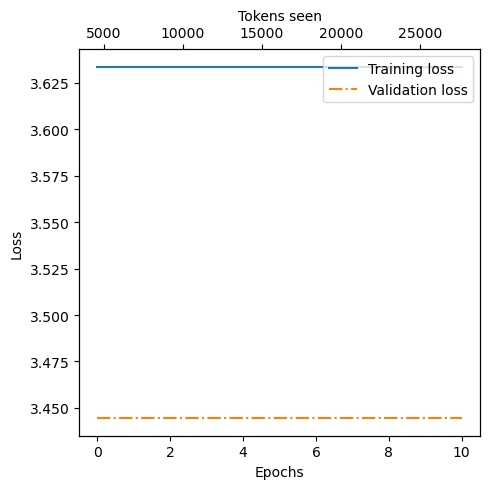

In [26]:
epochs_tensor = torch.linspace(0, num_epochs, len(train_losses))
plot_losses(epochs_tensor, tokens_seen, train_losses, val_losses)


In [27]:
token_ids = generate(
    model=gpt.to(device),
    idx=text_to_token_ids("Every effort moves ", tokenizer).to(device),
    max_new_tokens=30,
    context_size=copyConfig.context_length,
    top_k=1,
    temperature=1.0,
)

print("Output text:\n", token_ids_to_text(token_ids, tokenizer))


Output text:
 Every effort moves  to make the game more fun.
The game is a bit of a mess, but it's a fun game.
The game is a
